调用智谱ai的 `glm-4v-flash` 模型

In [1]:
from zhipuai import ZhipuAI

client = ZhipuAI(api_key="659b6a52115e4c7ba6a1ffcfe107ce74.JLtjL3ijzR6WT7CR")

def chat(query):
    response = client.chat.completions.create(
        model="glm-4v-flash", messages=[{"role": "user", "content": query}]
    )
    return response.choices[0].message.content

结合智谱ai，按要求修改论文信息

In [2]:
def abbreviate_name(full_name):
    """获取一个名字的简写

    Args:
        full_name (str): 姓名全拼

    Returns:
        str: 简写后的姓名，名在前、姓在后
    """
    parts = full_name.strip().split()
    if len(parts) < 2:
        return full_name

    first_names, last_name = parts[:-1], parts[-1]
    abb_first_names = [name[0].upper() for name in first_names]
    abb_name = ""
    for name in abb_first_names:
        abb_name += name + ". "
    abb_name += last_name.capitalize()
    return abb_name

In [19]:
import json

prompt = """下面是一个表示论文信息的dist，你需要对它进行一些修改，然后按照原格式返回，要求如下，你要一步步实现：
1. 作者姓名格式转换：请将作者姓名简写，名在前，姓在后
2. 合并字符串：将简写后的作者姓名合并为一个字符串，作者之间用逗号连接，如果多于三个作者，用“et.al”表示剩余作者
3. 关键词提取：TMLR的keywords字段都是空字符串，请根据TMLR论文的摘要，为每篇论文提取总结三个keywords
4. 代码链接提取：如果摘要中提到代码链接（如GitHub链接），将其提取出来并存储在新的字段“Code_src”中，如果摘要没有提供链接，“Code_src”字段为空
5. 摘要扩展：基于摘要内容，扩展一个简单的“Introduction”，简要介绍论文的背景、研究问题、方法和主要贡献
6. 论文主题分析：请根据论文的关键词字段对论文进行聚类分析，按研究主题将论文分为多个组，并为每篇论文分配一个主题标签，生成“Topic”字段，标明该论文属于哪个研究主题（如“生成模型”、“图像识别”、“强化学习”等）

将你返回的结果用<start>和<end>标记起来，如：<start>返回结果<end>。
待修改的论文信息如下：
"""


def modify_paper_metadata(paper):
    """按要求修改论文信息

    Args:
        paper (dict): 待修改的论文信息（json文件中各个对象）

    Returns:
        dict: 修改后的论文信息
    """
    # 1. 作者姓名格式转换
    authors = paper["authors"]
    new_authors = [abbreviate_name(author) for author in authors[:3]]

    # 2. 合并字符串
    authers_str = ", ".join(new_authors)
    if len(authors) > 3:
        authers_str += ", et.al"
    paper["authors"] = authers_str

    # 3. 关键词提取
    if "TMLR" in paper["venue"]:
        keywords = chat(
            "请根据下面的论文摘要，提取总结三个关键词（英文），按这种格式输出：word1, word2, word3\n"
            + paper["abstract"]
        )
        # print(f"ai keywords: {keywords}")
        paper["keywords"] = keywords.split(", ")

    # 4. 代码链接提取
    have_code_src = chat(
        "检查下面的论文摘要，其中是否提供了代码链接（如GitHub链接）？提供了则回答True，否则回答False：\n"
        + paper["abstract"]
    )
    if have_code_src == "True":
        code_src = chat(
            "根据下面的论文摘要，提取代码链接（如GitHub链接），直接返回链接：\n"
            + paper["abstract"]
        )
    else:
        code_src = ""
    paper["Code_src"] = code_src

    # 5. 摘要扩展
    introduction = chat(
        "根据下面的论文摘要，简单总结介绍一下论文的背景、研究问题、方法和主要贡献（用英文）：\n"
        + paper["abstract"]
    )
    paper["Introduction"] = introduction

    return paper

开始处理原 `json` 中的各论文信息
> 由于论文数量过多，而每次调用智谱api、等待其返回内容存在一定网络延迟，如果处理整个 `paper_metadata_1212_10k.json` 耗时会非常长，故这里只处理前1000条信息，并将修改后的结果保存到 `result.json` 中

In [20]:
input_file = "paper_metadata_1212_10k.json"
output_file = "result.json"

# 读取JSON文件
with open(input_file, "r", encoding="utf-8") as f:
    data = json.load(f)

# 对每个对象(paper)进行修改
modified_data = []
for i, paper in enumerate(data):
    modified_paper = modify_paper_metadata(paper)
    modified_data.append(modified_paper)
    print(f"Processed {i+1}/{len(data)} papers done.")
    if i + 1 >= 10:
        break

Processed 1/10526 papers done.
Processed 2/10526 papers done.
Processed 3/10526 papers done.
Processed 4/10526 papers done.
Processed 5/10526 papers done.
Processed 6/10526 papers done.
Processed 7/10526 papers done.
Processed 8/10526 papers done.
Processed 9/10526 papers done.
Processed 10/10526 papers done.


根据 `keywords` 对论文进行聚类分析

In [21]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import OpenAI
from sklearn.cluster import KMeans

keywords_list = [paper["keywords"] for paper in modified_data]
keywords_list

[['language modeling', 'memorization', 'dataset contamination'],
 ['architecture adaptation', 'expressivity bottleneck', 'neural network'],
 ['data-centric', 'model inversion attack', 'privacy preservation'],
 ['PreLowD', 'Factorized Fourier Neural Operator', 'Fine-tuning'],
 ['bootstrap', 'uncertainty quantification', 'survival analysis'],
 ['causal modeling', 'diffusion models', 'counterfactual inference'],
 ['Disentangled Representation Network',
  'Individualized Dose-Response Function',
  'Selection Bias Adjustment'],
 ['synthetic images', 'knowledge distillation', 'feature distillation'],
 ['DL rankers', 'Learning-to-Rank', 'tabular data'],
 ['calibration attack', 'adversarial defense', 'model uncertainty']]

In [27]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 确定最佳簇数（肘部法）
def determine_optimal_clusters(data, max_clusters=10):
    sse = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters + 1), sse, marker="o")
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.title("Elbow Method")
    plt.show()


# 确定最佳簇数（轮廓系数法）
# TODO 有bug
def determine_optimal_clusters_silhouette(data, max_clusters=10):
    silhouette_scores = []
    for k in range(2, min(max_clusters, len(data)) + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)

    plt.plot(range(2, min(max_clusters, len(data)) + 1), silhouette_scores, marker="o")
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Method")
    plt.show()

In [29]:
# 将每篇论文的关键词列表转换为字符串
documents = [" ".join(keywords) for keywords in keywords_list]

# 使用LangChain的OpenAIEmbeddings将关键词转换为向量
embeddings_model = OpenAIEmbeddings()
embeddings = embeddings_model.embed_documents(documents)

# # 使用FAISS进行向量存储和检索
# vector_store = FAISS(embeddings, documents)

# # 从向量存储中获取嵌入向量
# embeddings = vector_store.get_all_vectors()



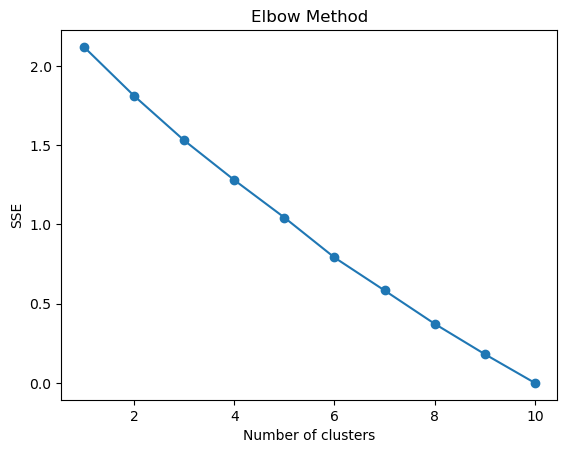

In [30]:
# 确定最佳簇数
determine_optimal_clusters(embeddings)

In [31]:
# 使用KMeans进行聚类
num_clusters = 3  # TODO 确定最佳簇数
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)

# 获取每篇论文的聚类标签
labels = kmeans.labels_

# 输出聚类结果
for i, label in enumerate(labels):
    print(f"论文 {i+1} 的聚类标签: {label}")

# 如果需要将聚类结果按标签分组
clusters = {}
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(keywords_list[i])

# 输出每个聚类的论文关键词
for label, cluster in clusters.items():
    print(f"\n聚类 {label} 包含的论文关键词:")
    for keywords in cluster:
        print(keywords)

论文 1 的聚类标签: 2
论文 2 的聚类标签: 0
论文 3 的聚类标签: 1
论文 4 的聚类标签: 0
论文 5 的聚类标签: 1
论文 6 的聚类标签: 1
论文 7 的聚类标签: 0
论文 8 的聚类标签: 2
论文 9 的聚类标签: 2
论文 10 的聚类标签: 1

聚类 2 包含的论文关键词:
['language modeling', 'memorization', 'dataset contamination']
['synthetic images', 'knowledge distillation', 'feature distillation']
['DL rankers', 'Learning-to-Rank', 'tabular data']

聚类 0 包含的论文关键词:
['architecture adaptation', 'expressivity bottleneck', 'neural network']
['PreLowD', 'Factorized Fourier Neural Operator', 'Fine-tuning']
['Disentangled Representation Network', 'Individualized Dose-Response Function', 'Selection Bias Adjustment']

聚类 1 包含的论文关键词:
['data-centric', 'model inversion attack', 'privacy preservation']
['bootstrap', 'uncertainty quantification', 'survival analysis']
['causal modeling', 'diffusion models', 'counterfactual inference']
['calibration attack', 'adversarial defense', 'model uncertainty']


In [32]:
# TODO 添加Topic字段
# 将修改后的内容写入新的JSON文件
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(modified_data, f, ensure_ascii=False, indent=4)